# Startup Example: Using the Graph Compiler Package Functionalities

## Objective

The goal of this objective is to introduce users to main classes used in our package. This document is primarily targeted to implementers, but may also be useful for other users. It also provides some explanations of python, where deemed useful

The generally used API will be denoted by **"""[Public API]"""** in the python code snippets; this is information that any users of the software should generally know, and we should aim to make few changes to that public interface.

Notes to the implementer will be denoated by **"""[Implementer info]"""**; this is information that would ordinarily be abstracted away from users, but that implementers need to know. This info will be subject to rapid change--if this document is failing/seems to be contradicting the code base, please feel free to update it to reflect the latest implementation information!

### Last modified: 2022-05-25

## Table of Contents

1. Building a Circuit (introduction to Operations, Circuit, RegisterCircuitDAG, and associated visualizations)
2. Creating a state (introduction to State and State Representations, and associated visualizations)
3. Run a Circuit (introduction to Compilers)
4. Solver and Metric APIs
5. Miscellaneous details (openQASM support)

Let's get into it!

## Building a Circuit
### Operation classes

We have a set of operations which can be sequentially applied to form a quantum circuit. Operations should have two conceptual features:
1. An operation type. This is the actual **class** of the Operation object, and tells us what kind of gate the operation corresponds to (e.g. Hadamard, pauli X, or CNOT)
2. A set of registers to which the operation is applied. **This tells us which qudit/cbits the gate must act on**. The number of registers provided should match the number of registers expected by the operation type

In [1]:
""" Public API """
# Declaring Operation objects
import src.ops as ops  # this import is necessary to access the operation classes

h = ops.Hadamard(register=0)
cnot = ops.CNOT(control=0, target=1)

**Python note**: in the preceding example, we chose to import the `ops.py` MODULE as `ops`. Then, to access any of its functions, we must write `ops.<function name>`. Alternatively, we could import specific classes (or functions) from `ops.py`:

In [2]:
""" Public API """
# Alternate import option
from src.ops import Hadamard, CNOT

h = Hadamard(register=0)
cnot = ops.CNOT(control=0, target=1)

### Operation Base Classes

Because we want to be able to support different state representations with few changes to the API, these operation objects **do not encode how we apply the operation to the state**. That is, there is no code in these Operation objects that tells us how they modify states (this is handled in the compiler, which we will get to).

Then, there is a lot of similarities between the implementation of these different operation objects. To avoid rewriting the code repeatedly (bad practice, since it means each change must be made in multiple places!), we use **base classes** which specific Operation objects (e.g. the Hadamard and CNOT viewed above) can INHERIT code.


#### OperationBase

All Operation classes **inherit** from `OperationBase`.

**Python note:** A child class (e.g. `Hadamard`) may inherit from a parent class (e.g. `OperationBase`). This means that you can call functions on a child which ARE NOT EXPLICITLY defined in the child, if they are explicitly defined in the parent--if the child does not have its own version of the function, the code called will be the parent-code.

Operation base has `q_registers` and `c_registers`, in which it saves the information of which quantum/classical registers of the circuit it must act on.

In [3]:
""" [Implementer Info] """

# Operation object which acts on quantum registers 0, 1 and classical register 0
base0 = ops.OperationBase(q_registers=(0, 1), c_registers=(0,))

# Careful, base0 may not be the same as base1! Order of register matters
base1 = ops.OperationBase(q_registers=(1, 0), c_registers=(1,))

# NOTE: the comma in c_registers=(0,) is necessary in python to make c_registers a TUPLE (iterable data) instead of an int

#### SingleQubitOperationBase, InputOutputOperationBase, ControlledPairOperationBase, ClassicalControlledPairOperationBase

All the above inherit from `OperationBase`: like `OperationBase`, they exist such that we can recycle code between similar operations (for example, all single-qubit unitary gates acting on qubits need similar info stored)

See `ops.py` for their precise implementations

#### The "real" operations

Finally, we get to the "real" operations which we want in our circuit (note that you can PLACE the base classes in the circuit object--mostly for testing purposes--but that the compiler will raise an error if you try to compile the base classes)

These include:

**SingleQubitOperationBase** types: Hadamard, SigmaX,SigmaY, SigmaZ

**ControlledPairOperationBase** types: CNOT, CPHASE

**ClassicalControlledPairOperationBase** types: classical CNOT/CPHASE
**OperationBase** type (though we may want another base class later for this, if we implement more): MeasurementZ

See the """[Public API] """ code above for examples of those.

### Registers

Some pieces software (e.g. qiskit, openQASM from IBM) support both **register indexing** and **(register, qubit) indexing** for their operations.

For example:

`two_qubit_op a b` would act on registers a, b (that is, we apply `two_qubit_op` $a[i], b[i] \forall i \in \{0,..., |A| - 1 = |B| - 1\}$ where $|A|$ is the number of qubits in A, $|B|$ is the number of qubits in B.

`two_qubit_op a b[i]` would act on register a, and qubit i of register b (that is, we apply `two_qubit_op`$a[j], b[i] \forall j \in \{0, ..., |A| - 1\}$

`two_qubit_op a[i] b` would act on qubit i of register a, and register b (that is, we apply `two_qubit_op`$a[i], b[j] \forall j \in \{0, ..., |B| - 1\}$

`two_qubit_op a[j] b[i]` would act on qubit j of register a, and qubit i of register b (that is, we apply `two_qubit_op`$a[j], b[i]$

Our software also supports this capabilities. We assume that assigning to an Operation an integer as a register refers to the full register, and that assigning to an operation a TUPLE as a register refers to the specific qubit.

This is discussed further under our `circuit.py` discussion

In [4]:
""" [Public API] """

# Index operation to the register 0
H_reg = Hadamard(register=0)

# Index operation to the register 0, qubit 0
H_reg_q = Hadamard(register=(0, 0))

# Index operation between registers
cnot_reg = CNOT(control=0, target=1)  # NOTE: register 0, 1 will need to have the same size in the circuit

# Index operation between a register, and a (reg, qubit) pair
cnot_reg_reg_q = CNOT(control=(0, 0), target=1)

# Index operation to two specific qubits
cnot_reg_q = CNOT(control=(0, 0), target=(0, 1))

#### Implementers note: what is @property, @<...>.setter?

Here's a python explanation if you're interested: https://www.freecodecamp.org/news/python-property-decorator/

In our code specifically, we use it so that when the `q_registers`/`c_registers` which are defined in `OperationBase` are modified in a child of `OperationBase`, the child will also update its `register` or `control, target` object fields. This becomes useful in the circuit class.

### The Circuit Class

The circuit class is built to remember with `Operation`-type objects to apply in each order.

Like with `OperationBase`, we have a base class called `Circuit` (to allow future software expansions). Unlike `OperationBase`, we only have one circuit implementation at the moment, called `RegisterCircuitDAG`.

`RegisterCircuitDAG` represents a circuit via a directed acyclic graph (DAG).

#### What is the DAG representation?

The circuit DAG representation is used by other simulator softwares such as qiskit (IBM). Each NODE of the graph corresponds to an operation. Each EDGE of the graph corresponds to a qubit.

The graph is directed because the operations have an order. The direction of the edges follows the direction of time.

The graph is acyclic, because each a loop would indicate that a certain operation A occurs both before and after a certain operation B.

Example:

![DAG example](img/circuit_dag_explanation.PNG "DAG Circuit Example")

#### What operations do circuits support?

Find out below...

In [5]:
""" Public API """
import src.ops as ops   # we did this earlier so not technically needed
from src.circuit import RegisterCircuitDAG

# NOTE: all the operations below are callable on any circuit object
# but... we will only have RegisterCircuitDAG implemented for the foreseeable future

# Create a circuit with 2 quantum registers and 1 classical registers
# If you don't specify n_quantum, n_classical, an empty circuit (no registers) is created by default
circuit = RegisterCircuitDAG(n_quantum=2, n_classical=0)

# Add Operations to the circuit to create a Bell state
circuit.add(Hadamard(register=0))
circuit.add(CNOT(control=0, target=1))

# Used for testing: make sure the circuit is "valid" (see docstring)
circuit.validate()  # will raise an AssertionError if not valid!

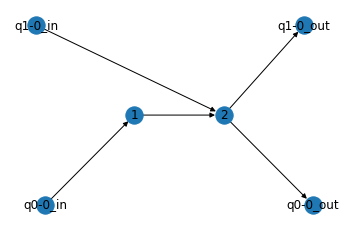

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [6]:
""" Public API """

# Great, we've built a circuit! Let's see what it looks like

circuit.draw_dag()

We see that node 1 seems to be the Hadamard, and node 2 is the CNOT.

In general, the operations are NUMBERED IN THE ORDER THEY WERE ADDED TO THE CIRCUIT. If you add an Operation on registers of size > 1, each pair of qubits affected by the Operation get their own number. **By default, registers are single-qubit registers**.

Ok, but it's not super easy to read this circuit... so we also provide a separate visualization function:

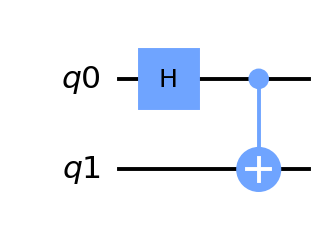

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [7]:
""" [Public API] """
circuit.draw_circuit()

The visualizations draw from our src.visualizer toolboxes (see below)

OPENQASM 2.0;

gate h a { U(pi/2, 0, pi) a; }

qreg q0[1];
qreg q1[1];

h q0[0];
CX q0[0], q1[0];


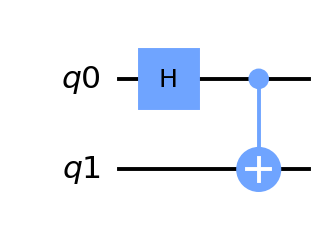

In [8]:
""" [Implementer info] """

# Behind the scenes, this is how we are making the circuit show
import matplotlib.pyplot as plt
from src.visualizers.openqasm_visualization import draw_openqasm

"""
First, we need to get a STRING of the openQASM code that matches our circuit...
This information is stored partly in the circuit and its Operations at 
runtime, and is queried from src.libraries.openqasm_lib.py

[Implementer info] New implemented Operations will need to have their openQASM definitions added
to be visualized!
"""

# Get openQASM representation of circuit
openqasm_str = circuit.to_openqasm()
print(openqasm_str)

# Draw the circuit (calls on qiskit functionalities right now)
# I wouldn't worry about the implementation, it's likely to change
fig, ax = plt.subplots()  # side note: ax is optional in general, but seems necessary in jupyter notebooks
draw_openqasm(openqasm_str, show=False, ax=ax)
plt.show()

#### Get a sequence of operations

In our software, the circuit is responsible for providing the compiler with a sequence of operations to compile. This sequence is built from the nodes of the graph provided in "topological" order:

In [9]:
op_seq = circuit.sequence()
print("operation objects (sequence):")
print(op_seq)

operation objects (sequence):
[<src.ops.Input object at 0x0000028E4A2DD7F0>, <src.ops.Input object at 0x0000028E4A2DD7C0>, <src.ops.Hadamard object at 0x0000028E6D00ABE0>, <src.ops.CNOT object at 0x0000028E6D00AC40>, <src.ops.Output object at 0x0000028E4A2DD820>, <src.ops.Output object at 0x0000028E6A20ED60>]


#### Working with registers

As mentioned under Operations, we may want to allow both single-qubit quantum registers and multi-qubit quantum registers (where the registers act as a "shortcut command" for applying operation on multiple qubits at once).

We don't (in general) want our solver to be CONSTRAINED to only using the registers it started with. As such, we provide a few mechanisms to expand the circuit:
1. `add_quantum_register(size=<desired size of new register>)`/`add_classical_register(size=<desired size of new register>)`. These allow us to explicitly create a new register of a certain size.
2. `expand_quantum_register(register, new_size)`/`expand_classical_register(register, new_size)`. This allows us to explicitly expand a previously created register
3. Adding an Operation using `circuit.add(op)` as above, where `op` contains a previously not included register (though careful! The register numbers must remain continuous or an error will be raised.

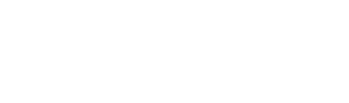

In [10]:
"""[Public API]"""

# Create an empty circuit to start
circuit = RegisterCircuitDAG()
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show()  # NOTE: we see just a white square... because it's empty!

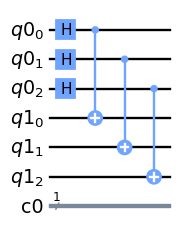

In [11]:
"""[Public API]"""


# 1. Add 2 quantum registers of size 3, 1 classical register of size 1
circuit = RegisterCircuitDAG()

circuit.add_quantum_register(size=3)
circuit.add_quantum_register(size=3)
circuit.add_classical_register(size=1)

# Add a Hadamard on register 0, then a CNOT between 0 and 1, because why not
circuit.add(Hadamard(register=0))
circuit.add(CNOT(control=0, target=1))

fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show()

Now we may decide that we actually want a classical register of size 3 as well...

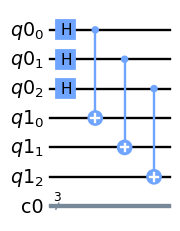

In [12]:
"""[Public API]"""

# 2. expand classical register to a size of 3
circuit.expand_classical_register(0, 3)  # expand register 0 to be of size 3
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show() # notice the little "3" by c0

We could also expand quantum registers 0 and 1. **CAREFUL HOWEVER! As things are currently implemented, the register will expand but the gates which were previously applied to the full register will NOT be applied to the new qubits added to said register**

This may change in the future depending on choices we make with the solver... But this is the way things are now:

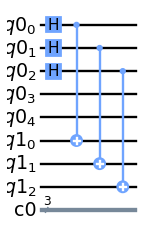

In [13]:
"""[Public API]"""

# 2. expand quantum register 0 to a size of 5
circuit.expand_quantum_register(0, 5)  # expand register 0 to be of size 3
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show()

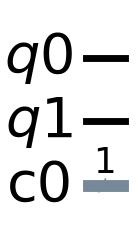

In [14]:
"""[Public API]"""

# 3. Expanding quantum registers by adding Operations
circuit = RegisterCircuitDAG(2, 1)  # we start with two qreg of size 1, 1 creg of size 1
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show()

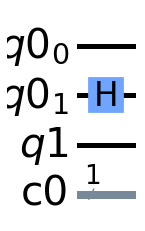

In [15]:
"""[Public API]"""

# We can create a second qubit in register q0 by adding an operation on it
circuit.add(Hadamard(register=(0, 1)))
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show()

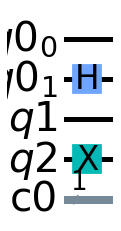

In [16]:
"""[Public API]"""

# We can create a new register q2 in the same way
circuit.add(ops.SigmaX(register=2))
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=False, ax=ax)
plt.show()

In [17]:
"""[Public API]"""

# However, qubits must be added consecutively (we cannot add a qubit 3 to q0)
# but we COULD add a qubit 2 at the moment)
try:
    circuit.add(ops.SigmaZ(register=(0, 3)))
except ValueError as v:
    print(v)
    
# Similarly, registers must be consecutive (i.e. we can add q3 but not q4, q5, q7 for example)
try:
    circuit.add(ops.Hadamard(register=7))
except ValueError as v:
    print(v)

Non-consecutive qudit/cbit indexing!
Register numbering must be continuous. Quantum register 7 cannot be added.Next register that can be added is 3


In [18]:
"""[Public API]"""

# Thankfully finding the next qubit of a register is easy
print(f'next q0 qubit: {circuit.next_qubit(0)}')
print(f'next c0 cbit: {circuit.next_cbit(0)}')

next q0 qubit: 2
next c0 cbit: 1


#### Circuit Implementation 

Each circuit remembers its own `q_registers` and `c_registers` lists, where `q_registers[i]` corresponds to the number of qubits in quantum register i (and ditto for `c_registers`).

When an Operation is added to the circuit, the class does the following:
1. Save openqasm information (don't worry about this, not super important outside of visualization)
2. It will look at the registers provided in the Operation, and add the registers to `q/c_registers` as needed in `_add_reg_if_absent`. For each new register the circuit adds Input/Output NODES to its graph representation, and adds an edge between these input/outputs --> this makes the circuit DAG "valid" (i.e. all registers are represented and we progress from input to output)
3. It will then add the Operation itself to the circuit. The Operation is added as a NODE between the register output nodes and any previous operations on the register

**FINALLY, operations are not DIRECTLY added to graphs. Instead, each Operation is decomposed into a series of Operations that act specific groups of qubits (rather than full registers)**

That is, `Hadamard(register=1)` gets added to the circuit as `Hadamard(register=(1, 0))`, `Hadamard(register=(1, 1))`, `Hadamard(register=(1, 2))` if register 1 is of size 3.

There are more details, but those are the important bits

## Creating a State

There are two state representations currently implemented:
1. The Density Matrix state representation `DensityMatrix`
2. The Graph state representation `Graph`

This is not fully implemented yet, but we also intend to have a `QuantumState` "wrapper" class which holds all individual representations in a given simulation and provides an accessible API for accessing different representations, and converting between representations.

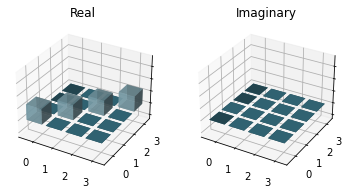

In [19]:
""" [Public API] """

# Create a quantum state class.
# For now, it can support either a ndarray data input (for density matrix representations) or a graph input (both)
# or an integer input (graph only, but soon to be both)

# Density matrix initialization
import numpy as np

from src.state import QuantumState

n = 2
data = np.eye(2 ** n)
state = QuantumState(n, data, representation='density matrix')

# We can visualize the density matrix
# Note: we have a quantum_state.show() function but it's not implemented yet, so we'll just use the representation-specific visualization tool

from src.visualizers.density_matrix import density_matrix_bars
fig, ax = density_matrix_bars(state.dm.data)
plt.show()

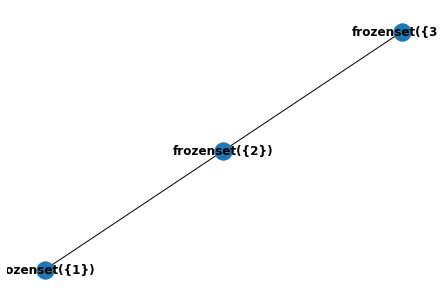

In [20]:
""" [Public API] """

# We can also create a quantum state based on a graph representation
import networkx as nx

n = 3
data = nx.Graph([(1, 2), (2, 3)])
state = QuantumState(n, data, representation='graph')

from src.visualizers.graph import draw_graph
draw_graph(state.graph)

In [21]:
""" [Public API] """

# Now, the following isn't implemented yet but it should be soon--we want to be able to query a representation we DID NOT
# initialize --> that is, the QuantumState object should wrap our conversions from state to state

try:
    print(state.dm)
except ValueError as v:
    print(v)

Cannot convert existing representation to density matrices


#### Density Matrix Representation

Typically, all the internal manipulations on the states will be done by a `compiler` (see next section). 

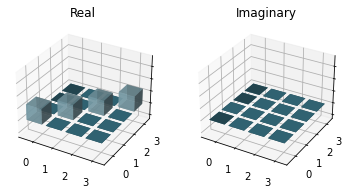

In [22]:
""" [Implementer info] """

# Density matrices can be initializes from numpy ndarrays
# (they are in fact implemented as ndarrays, with various helpful functions
# with which the compiler can apply Operations to it)
from src.backends.density_matrix.state import DensityMatrix


n = 2
data = np.eye(2 ** n)
dm = DensityMatrix(data)

fig, ax = density_matrix_bars(dm.data)
plt.show()

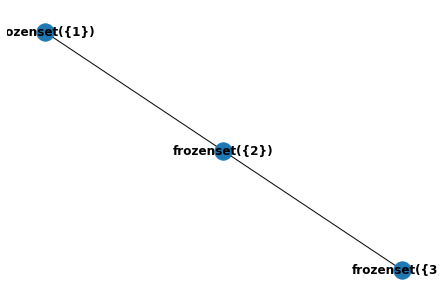

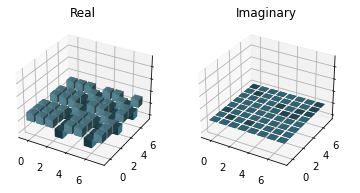

In [23]:
""" [Implementer info] """

# However, density matrices representations can also be initialized
# from nx.Graph or our own Graph representations objects
from src.backends.graph.state import Graph

data = nx.Graph([(1, 2), (2, 3)])
g = Graph(data, 1)  # 1 is the "root node id"

draw_graph(g)

dm_ex = DensityMatrix.from_graph(g)
density_matrix_bars(dm_ex.data)
plt.show()

There are two manipulations that are supported on `DensityMatrix` objects: unitary transformations (`apply_unitary`) and measurements (`apply_measurement`). Both are implemented through a number of numpy functions.

These are used by the compiler to evolve the state through operations.

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

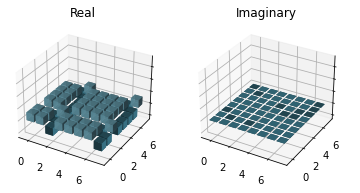

In [24]:
# We can apply a unitary (which we can load from density_matrix.functions)
import src.backends.density_matrix.functions as dm

# Apply pauli x
n = 3
unitary = dm.get_single_qubit_gate(n, 0, dm.sigmax())  # get the gate
dm_ex.apply_unitary(unitary)
density_matrix_bars(dm_ex.data)

outcome: 0


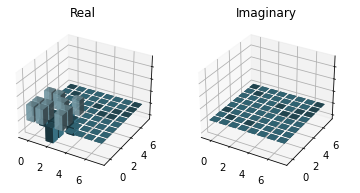

In [25]:
# Similarly, we can apply a measurement
projectors = dm.projectors_zbasis(n, 0)
outcome = dm_ex.apply_measurement(projectors)
density_matrix_bars(dm_ex.data)
print(f'outcome: {outcome}')

The Graph state representation has many more available functions, largely for graph manipulation (e.g. adding nodes and edges). They will be available for use for when we write a graph compiler (can be viewed under `src/backends/graph/state.py`)

## Run a Circuit

We can run a circuit (i.e. get its output) by *compiling* the circuit.

We have a set of benchmark circuits we can load from `benchmarks/circuits.py`

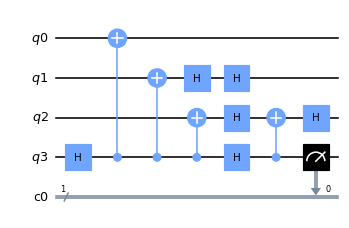

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

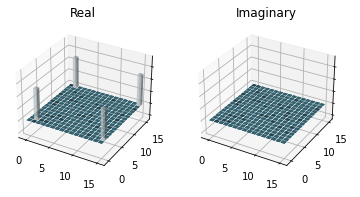

In [26]:
# load a circuit

import benchmarks.circuits as circ
from src.backends.density_matrix.compiler import DensityMatrixCompiler

circuit, _ = circ.ghz3_state_circuit()
fig, ax = plt.subplots()
draw_openqasm(circuit.to_openqasm(), show=True, ax=ax)

# Create a compiler object -- right now we only have the density matrix compiler
compiler = DensityMatrixCompiler()
dm_state = compiler.compile(circuit)

density_matrix_bars(dm_state.data)

#### Compiler Implementation

The plan is to have multiple different compilers---at least one per representation type, but also likely compilers which use multiple representations at once.

At a high level, compilers work this way:
1. Get an initial state (right now, the initial state is created in the compiler--this may chhange in the future)
2. Pick out a sequence of Operations to execute using `circuit.sequence()`
3. For each element of the sequence, use state-representation-specific methods to evolve the state (for the DensityMatrixCompiler, this means using the `apply_unitary` and `apply_measurement` functions

Point 3 is currently implemented with a loop which goes through each Operation, and with a series of if-statement that covers each operation allowed by the compiler.